#### General information

http://slepc.upv.es/slepc4py-current/docs/usrman/install.html#using-pip-or-easy-install


http://slepc.upv.es/handson/handson1.html



**How to calculate the smallest eigenvalues (instead of the biggest)**:

http://slepc.upv.es/documentation/current/docs/manualpages/EPS/EPSSetWhichEigenpairs.html#EPSSetWhichEigenpairs

`opts.setValue("eps_smallest_magnitude", 1)`

    
    

In [15]:
import sys, slepc4py
slepc4py.init(sys.argv)

# Next, we have to import the relevant modules. Normally, both PETSc and SLEPc modules have to be imported in all slepc4py programs. It may be useful to import NumPy as well:

from petsc4py import PETSc
from slepc4py import SLEPc
import numpy
np.set_printoptions(linewidth=270, precision=4)

# At this point, we can use any petsc4py and slepc4py operations. For instance, the following lines allow the user to specify an integer command-line argument n with a default value of 30 (see the next section for example usage of command-line options):

opts = PETSc.Options()
n = opts.getInt('n', 3000)
opts.setValue("eps_max_it", 100000)
opts.setValue("eps_smallest_magnitude", 1)


opts.setValue("eps_nev", 10)


# It is necessary to build a matrix to define an eigenproblem (or two in the case of generalized eigenproblems). The following fragment of code creates the matrix object and then fills the non-zero elements one by one. The matrix of this particular example is tridiagonal, with value 2 in the diagonal, and -1 in off-diagonal positions. See petsc4py documentation for details about matrix objects:

A = PETSc.Mat().create()
A.setSizes([n, n])
A.setFromOptions()
A.setUp()

rstart, rend = A.getOwnershipRange()

# first row
if rstart == 0:
    A[0, :2] = [2, -1]
    rstart += 1
# last row
if rend == n:
    A[n-1, -2:] = [-1, 2]
    rend -= 1
# other rows
for i in range(rstart, rend):
    A[i, i-1:i+2] = [-1, 2, -1]

A.assemble()

# The solver object is created in a similar way as other objects in petsc4py:

E = SLEPc.EPS(); E.create()

# Once the object is created, the eigenvalue problem must be specified. At least one matrix must be provided. The problem type must be indicated as well, in this case it is HEP (Hermitian eigenvalue problem). Apart from these, other settings could be provided here (for instance, the tolerance for the computation). After all options have been set, the user should call the setFromOptions() operation, so that any options specified at run time in the command line are passed to the solver object:

E.setOperators(A)
E.setProblemType(SLEPc.EPS.ProblemType.HEP)
E.setFromOptions()

# After that, the solve() method will run the selected eigensolver, keeping the solution stored internally:






In [2]:
%time E.solve()

CPU times: user 3.81 s, sys: 2.7 s, total: 6.51 s
Wall time: 1.73 s


In [3]:
# Print = PETSc.Sys.Print
Print = print

Print()
Print("******************************")
Print("*** SLEPc Solution Results ***")
Print("******************************")
Print()

its = E.getIterationNumber()
Print("Number of iterations of the method: %d" % its)

eps_type = E.getType()
Print("Solution method: %s" % eps_type)

nev, ncv, mpd = E.getDimensions()
Print("Number of requested eigenvalues: %d" % nev)

tol, maxit = E.getTolerances()
Print("Stopping condition: tol=%.4g, maxit=%d" % (tol, maxit))


******************************
*** SLEPc Solution Results ***
******************************

Number of iterations of the method: 2206
Solution method: krylovschur
Number of requested eigenvalues: 10
Stopping condition: tol=1e-08, maxit=100000


In [12]:
nconv = E.getConverged()
Print("Number of converged eigenpairs %d" % nconv)
kk = []
if nconv > 0:
    # Create the results vectors
    vr, wr = A.getVecs()
    vi, wi = A.getVecs()
    #
    Print()
    Print("        k          ||Ax-kx||/||kx|| ")
    Print("----------------- ------------------")
    for i in range(nconv):
        k = E.getEigenpair(i, vr, vi)
        kk.append(k)
        error = E.computeError(i)
        if k.imag != 0.0:
            Print(" %9f%+9f j %12g" % (k.real, k.imag, error))
        else:
            Print(" %12f      %12g" % (k.real, error))
    
    kk = np.array(kk)
    Print()

Number of converged eigenpairs 11

        k          ||Ax-kx||/||kx|| 
----------------- ------------------
     0.000001       2.44656e-08
     0.000004       7.39994e-09
     0.000010       2.55254e-09
     0.000018       4.22676e-09
     0.000027         1.597e-09
     0.000039       3.96912e-09
     0.000054       1.32783e-09
     0.000070       1.59263e-09
     0.000089       1.45552e-09
     0.000110        4.0202e-09
     0.000133       6.58014e-09



In [5]:
import numpy as np
import scipy as sc
import scipy.sparse
import scipy.sparse.linalg

In [6]:
# convert to numpy array
Anp = A[:,:]

In [7]:
%time r0 = np.linalg.eigvals(Anp)

CPU times: user 51.9 s, sys: 20 s, total: 1min 11s
Wall time: 20 s


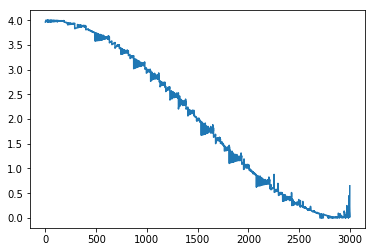

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(r0)

In [9]:
A_csc = sc.sparse.csc_matrix(Anp)

A_csr = sc.sparse.csr_matrix(Anp)

In [10]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigs.html
# which="SM" -> smalles magnitude

# only the 6 smallest Eigenvalues are calculated

%time r1 = sc.sparse.linalg.eigs(A_csc, which="SM")
%time r2 = sc.sparse.linalg.eigs(A_csr, which="SM")

print(r1)
print(r2)

CPU times: user 26.4 s, sys: 29.5 s, total: 56 s
Wall time: 16.2 s
CPU times: user 22.7 s, sys: 22.7 s, total: 45.4 s
Wall time: 12.3 s
(array([1.09589189e-06+0.j, 4.38356638e-06+0.j, 9.86301985e-06+0.j,
       1.75342463e-05+0.j, 2.73972373e-05+0.j, 3.94519821e-05+0.j]), array([[ 2.70250059e-05+0.j,  5.40499823e-05+0.j, -8.10748994e-05+0.j,
        -1.08099728e-04+0.j, -1.35124437e-04+0.j,  1.62148999e-04+0.j],
       [ 5.40499823e-05+0.j,  1.08099728e-04+0.j, -1.62148999e-04+0.j,
        -2.16197560e-04+0.j, -2.70245173e-04+0.j,  3.24291601e-04+0.j],
       [ 8.10748994e-05+0.j,  1.62148999e-04+0.j, -2.43221499e-04+0.j,
        -3.24291601e-04+0.j, -4.05358504e-04+0.j,  4.86421409e-04+0.j],
       ...,
       [ 8.10748994e-05+0.j, -1.62148999e-04+0.j, -2.43221499e-04+0.j,
         3.24291601e-04+0.j, -4.05358504e-04+0.j, -4.86421409e-04+0.j],
       [ 5.40499823e-05+0.j, -1.08099728e-04+0.j, -1.62148999e-04+0.j,
         2.16197560e-04+0.j, -2.70245173e-04+0.j, -3.24291601e-04+0.j],


In [16]:
# verify that the results are equivalent

print(kk[:6] - r1[0])
print(kk[:6] - r2[0])

[-1.3004e-16+0.j -4.7375e-17+0.j -6.8432e-17+0.j -2.0634e-17+0.j -4.9589e-17+0.j  2.4645e-17+0.j]
[-2.2420e-16+0.j -9.2711e-17+0.j -9.9823e-17+0.j -5.7771e-17+0.j -8.0817e-17+0.j -1.1676e-17+0.j]


**Conclusion:** `selpc` is faster approx. by factor 30 than `sc.sparse.linalg` and even more compared to `np.linalg`.